# Low Pass Filters (LPF) and High Pass Filter (HPF) Project
### Hesam Mohebi

### Low Pass Filters
LPF allows low frequency components of a signal pass through the filter while attenuating higher frequencies. One simple lows pass filter is average window, where it convolves the input signal with a window of average value
$$
y_{\text{LPF}}[n] = \sum_{k=0}^{N-1} x[n - k] \cdot w[k]
$$
### High Pass Filter
HPF allows high frequency components of a signal pass though the filter while attenuating lower frequencies. For implementing the HPF using the average window, we just subtract the result of LPF from the original signal
$$
y_{\text{HPF}}[n] = x[n] - y_{\text{LPF}}[n]
$$

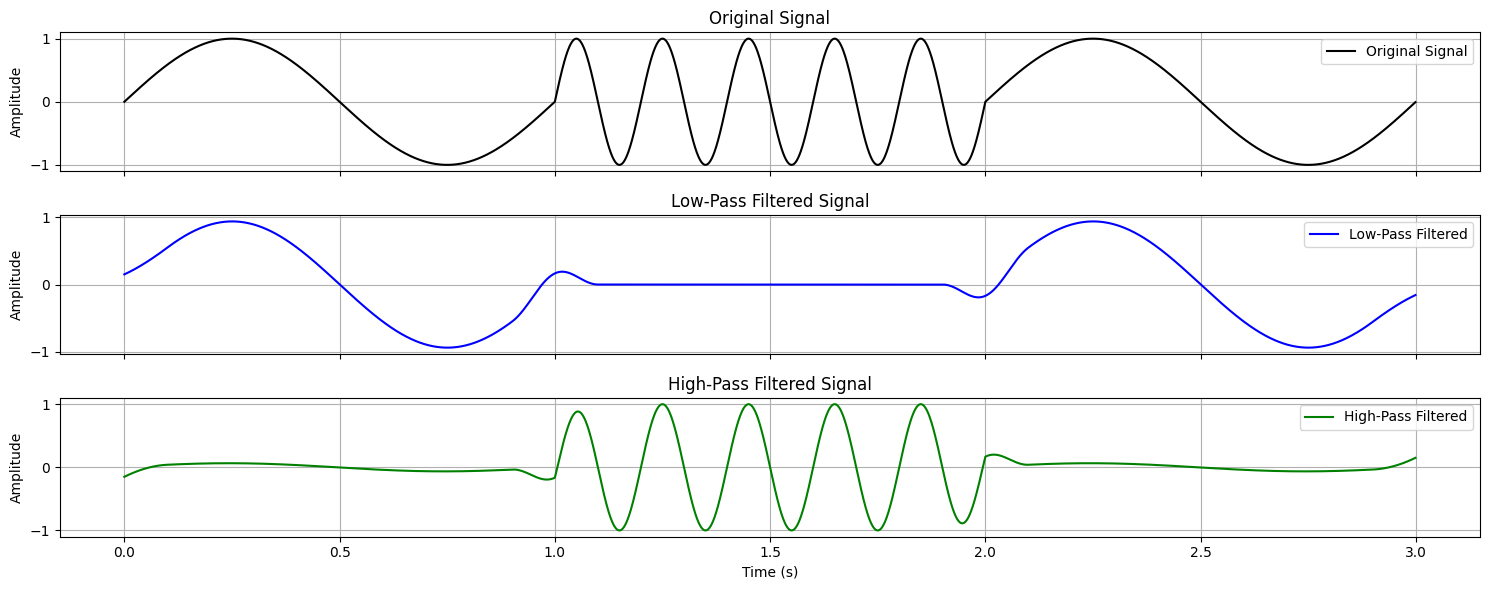

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import fft

# Parameters
fs = 1000  # Sampling frequency
t_total = 3  # Total duration in seconds
t = np.linspace(0, t_total, fs * t_total, endpoint=False)  # Time vector

# Define frequency changes for each segment
f1, f2, f3 = 1, 5, 1  # Frequencies for different segments

# Generate signal for each segment
signal_part1 = np.sin(2 * np.pi * f1 * t[t < 1])  # First segment (low frequency)
signal_part2 = np.sin(2 * np.pi * f2 * t[(t >= 1) & (t < 2)])  # Second segment (high frequency)
signal_part3 = np.sin(2 * np.pi * f3 * t[t >= 2])  # Third segment (low frequency)

# Concatenate the full signal
signal = np.concatenate([signal_part1, signal_part2, signal_part3])

# Simple moving average low-pass filter
def low_pass_filter(signal, window_size=200):
    """
    Applies a simple moving average low-pass filter.
    windows_size determines number of samples to average over.
    the larget the window_size the more smoother the signal is.
    the smaller the windows_size less smoothing is applied.
    np.ones(window_size)/window_size creates a window of size window_size with all values equal to 1/window_size

    Original Signal:   [2, 3, 8, 10, 12, 7, 5, 3, 1]
    Window (N=3 avg):  [1/3, 1/3, 1/3]
    Filtered Signal:   [ (2+3+8)/3, (3+8+10)/3, (8+10+12)/3, ... ]
                       [ 4.3, 7, 10, 9.6, 8, 5, 3 ]
    """
    filtered_signal = np.convolve(signal, np.ones(window_size)/window_size, mode='same') 
    # mode='same' returns the same length as the input signal

    return filtered_signal

# High-pass filter by subtracting the low-pass version from the original
def high_pass_filter(signal, window_size=200):
    """Applies a high-pass filter by removing low-frequency components."""
    return signal - low_pass_filter(signal, window_size)

# Apply filters
low_passed_signal = low_pass_filter(signal)
high_passed_signal = high_pass_filter(signal)

# Define plot dimensions
plot_width = 15  
plot_height = 6  

# Create subplots for all three signals
fig, axes = plt.subplots(3, 1, figsize=(plot_width, plot_height), sharex=True)

# Plot original signal
axes[0].plot(t, signal, label="Original Signal", color="black")
axes[0].set_ylabel("Amplitude")
axes[0].set_title("Original Signal")
axes[0].legend()
axes[0].grid()

# Plot low-pass filtered signal
axes[1].plot(t, low_passed_signal, label="Low-Pass Filtered", color="blue")
axes[1].set_ylabel("Amplitude")
axes[1].set_title("Low-Pass Filtered Signal")
axes[1].legend()
axes[1].grid()

# Plot high-pass filtered signal
axes[2].plot(t, high_passed_signal, label="High-Pass Filtered", color="green")
axes[2].set_xlabel("Time (s)")
axes[2].set_ylabel("Amplitude")
axes[2].set_title("High-Pass Filtered Signal")
axes[2].legend()
axes[2].grid()

# Adjust layout for better readability
plt.tight_layout()
plt.show()


##### Above is a simple time series signal with low and high frequency components. We have used window averaging filter to attenuate high frequency and for LPF and subtracted its result from the orignal signal to filter out the low frequency component. It can be seen that the higher windows size will result in more intense attenuation. 

### LPF and HPF in Image Processing
Now that we are familiar with overall concepts of LPF and HPF, lets discuss about them in the context image processing and undrestand different types of filtering.

*   A LPF on an image will result in blurrying, noise reduction (by averaging neighbors), smoothing texture and gradient, and removes the sharp edges and details.
*   LPF is often implemented with convolution using a smoothing kernel :
$$
I_{\text{LPF}}(x,y) = \sum_{i=-N}^{N} \sum_{j=-N}^{N} I(x + i, y + j) \cdot w(i, j)
$$

*   A HPF on an image will sharpen the image, enhances edges and fine details.
*   HPF is often applied using convolution with an edge-detection kernel and is equal to the subtraction of LPF from the original signal
$$
I_{\text{HPF}}(x,y) = I(x,y) - I_{\text{LPF}}(x,y)
$$

### Filtering Proccess
To filter an image in frequency doamain we should follow these steps:
1. Compute the DFT of the image: $$F(u,v) $$
2. Select an appropriate filter: $$H(u,v)$$
3. multiply F(u,v) by a filter function H(u,v): $$ G(u,v)=H(u,v)F(u,v)$$
4. Compute the inverse of DFT of G(u,v)

In the following sectiong we're going to implement and analyze:
1. Frequency domain filters (Ideal LPF and HPF, Butterworth, Gaussia)
2. Spatial domain filters (Mean, Median)
3. Laplacian, Sobel, Prewittfilters and compare their outputs.

(-0.5, 1110.5, 1082.5, -0.5)

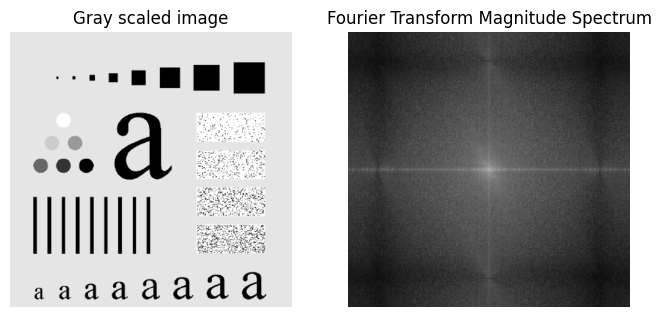

In [19]:
from skimage import color
from scipy.signal import convolve2d

img = plt.imread('text_sample.png')
# Check if the image has an alpha channel (RGBA)
if img.shape[-1] == 4:
    img = img[:, :, :3]  # Remove the alpha channel (keep only RGB)
img = color.rgb2gray(img)
# Fourier transform 
F = np.fft.fft2(img)
F_shifted = np.fft.fftshift(F)  # Shift zero components to the center
# Compute the magnitude spectrum for visualization
magnitude_spectrum = np.log(1 + np.abs(F_shifted))  # Log transform for better visibility

# Display the filter mask and the filtered image
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(img, cmap='gray')
plt.title('Gray scaled image')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(magnitude_spectrum, cmap='gray')
plt.title('Fourier Transform Magnitude Spectrum')
plt.axis('off')

### Ideal LPF:
Removes all the frequencies above a certain cutoff frequency:
$$
H(f) =
\begin{cases} 
1, & f \leq f_c \\
0, & f > f_c
\end{cases}
$$

*   This filter will result in strong bluring but ringing artifacts due to the sharp cutoff

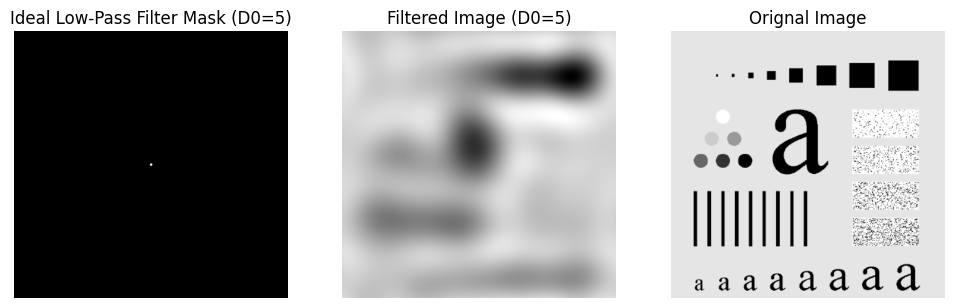

In [ ]:
def Ideal_LPF(img, D0):

    """creating an ideal low pass filter
    """
    M, N = img.shape
    H = np.zeros((M, N), dtype=np.float32)

    # Looping through each pixel in the frequency domain, and computing the Euclidean distance from the center
    # where low frequencies are located
    for u in range(M):
        for v in range(N):
            # distant from the center 
            D = np.sqrt((u - M / 2) ** 2 + (v - N/2) ** 2)
            if D < D0:
                H[u, v] = 1
            else:
                H[u, v] = 0
    return H
# Applying the filter to the frequency domain
D0=5
H = Ideal_LPF(img, D0)
F_filtered = F_shifted * H # Element-wise multiplication low frequency pass and high frequency zero
F_ishift = fft.ifftshift(F_filtered) # Shift zero components back to the corners
ideal_LPF_img_filtered = np.abs(fft.ifft2(F_ishift)) # abs() ensures that the results are real numbers since ifft2() may return complex numbers.

# Display the filter mask and the filtered image
plt.figure(figsize=(12,6))
plt.subplot(1,3,1)
plt.imshow(H, cmap='gray')
plt.title('Ideal Low-Pass Filter Mask (D0={})'.format(D0))
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(ideal_LPF_img_filtered, cmap='gray')
plt.title('Filtered Image (D0={})'.format(D0))
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(img, cmap='gray')
plt.title('Orignal Image')
plt.axis('off')

plt.show()

### Butterworth LPF:
 Smoothly transitions between passed and blocked frequencies.

$$
H(u,v) = \frac{1}{1 + \left( \frac{D(u,v)}{D_0} \right)^{2n}}
$$

*   It reduces ringing effect compared to ideal LPF
*   It provides a better control over bluring 

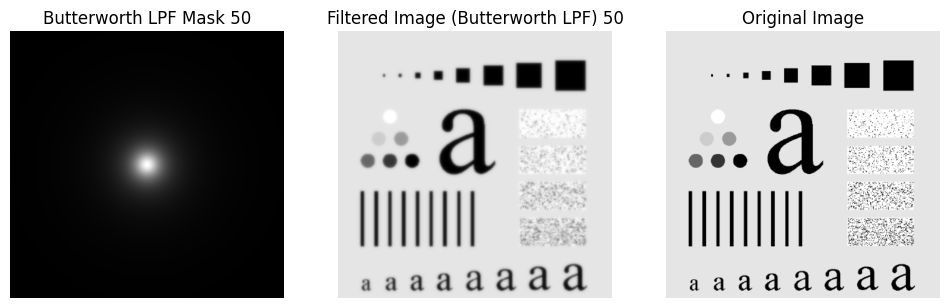

In [ ]:
def butterworth_LPF(img, D0=30, n=1):
    """
    Creates a Butterworth low-pass filter of size (M, N) with cutoff frequency D0 and order n.
    """
    M, N = img.shape

    H = np.zeros((M, N), dtype=np.float32)  # Initialize filter mask

    for u in range(M):
        for v in range(N):
            # Compute distance from center (low frequencies are at the center)
            D = np.sqrt((u - M / 2) ** 2 + (v - N / 2) ** 2) # Euclidean distance
            # Butterworth function: smooth transition
            H[u, v] = 1 / (1 + (D / D0) ** (2 * n)) # Butterworth function

    return H

D0 = 50
H_butterworth = butterworth_LPF(img, D0)

# Apply Fourier Transform and shift zero frequency component to center

F_filtered = F_shifted * H_butterworth # Element-wise multiplication

# Inverse Fourier Transform to get the filtered image
F_ishift = fft.ifftshift(F_filtered) # Shift zero components back to the corners
butterworth_img_filtered = np.abs(fft.ifft2(F_ishift)) # abs() ensures that the results are real numbers since ifft2() may return complex numbers.

# Plot the results
fig, ax = plt.subplots(1, 3, figsize=(12, 6))

ax[0].imshow(H_butterworth, cmap='gray')
ax[0].set_title("Butterworth LPF Mask {}".format(D0))
ax[0].axis('off')

ax[1].imshow(butterworth_img_filtered, cmap='gray')
ax[1].set_title("Filtered Image (Butterworth LPF) {}".format(D0))
ax[1].axis('off')

ax[2].imshow(img, cmap='gray')
ax[2].set_title("Original Image")
ax[2].axis('off')

plt.show()

### Gaussian LPF
Uses a Gaussian function for smoothing 

$$
H(u,v) = e^{-\frac{D^2(u,v)}{2 \ D0 ^2}}
$$

*   Smoothing the image while minimizing the ringing artifacts
*   It is used for denoising, image bluring, and anti-aliasing 


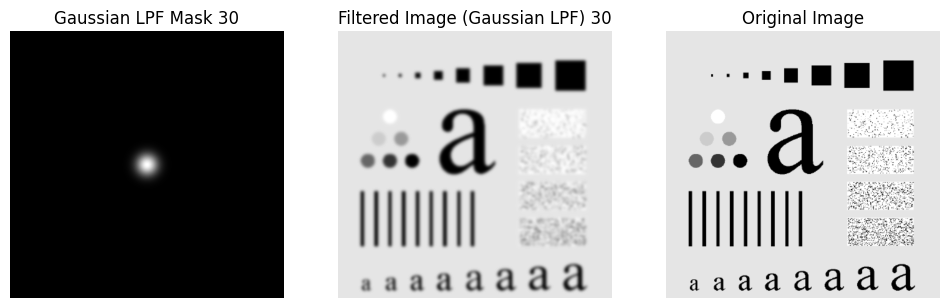

In [ ]:
# Define the Gaussian Low-Pass Filter function
def gaussian_LPF(img, D0=30):
    """
    Creates a Gaussian low-pass filter of size (M, N) with cutoff frequency D0.
    """
    M, N = img.shape

    H = np.zeros((M, N), dtype=np.float32)  # Initialize filter mask

    for u in range(M):
        for v in range(N):
            # Compute distance from center (low frequencies are at the center)
            D = np.sqrt((u - M / 2) ** 2 + (v - N / 2) ** 2) # Euclidean distance
            # Gaussian function: smooth transition
            H[u, v] = np.exp(- (D ** 2) / (2 * (D0 ** 2)))# Gaussian function

    return H

# Define cutoff frequency for Gaussian LPF
D0 = 30

# Generate Gaussian LPF mask
H_gaussian = gaussian_LPF(img, D0)

# Apply the Gaussian filter in the frequency domain
F_filtered_gaussian = F_shifted * H_gaussian

# Inverse Fourier Transform to get the filtered image
F_ishift_gaussian = fft.ifftshift(F_filtered_gaussian) # Shift zero components back to the corners
gaussian_img_filtered = np.abs(fft.ifft2(F_ishift_gaussian)) # abs() ensures that the results are real numbers since ifft2() may return complex numbers.

# Plot the results
fig, ax = plt.subplots(1, 3, figsize=(12, 6))

ax[0].imshow(H_gaussian, cmap='gray')
ax[0].set_title("Gaussian LPF Mask {}".format(D0))
ax[0].axis('off')

ax[1].imshow(gaussian_img_filtered, cmap='gray')
ax[1].set_title("Filtered Image (Gaussian LPF) {}".format(D0))
ax[1].axis('off')

ax[2].imshow(img, cmap='gray')
ax[2].set_title("Original Image")
ax[2].axis('off')

plt.show()


### Comparison betweeen Frequency Domain filters on different values 

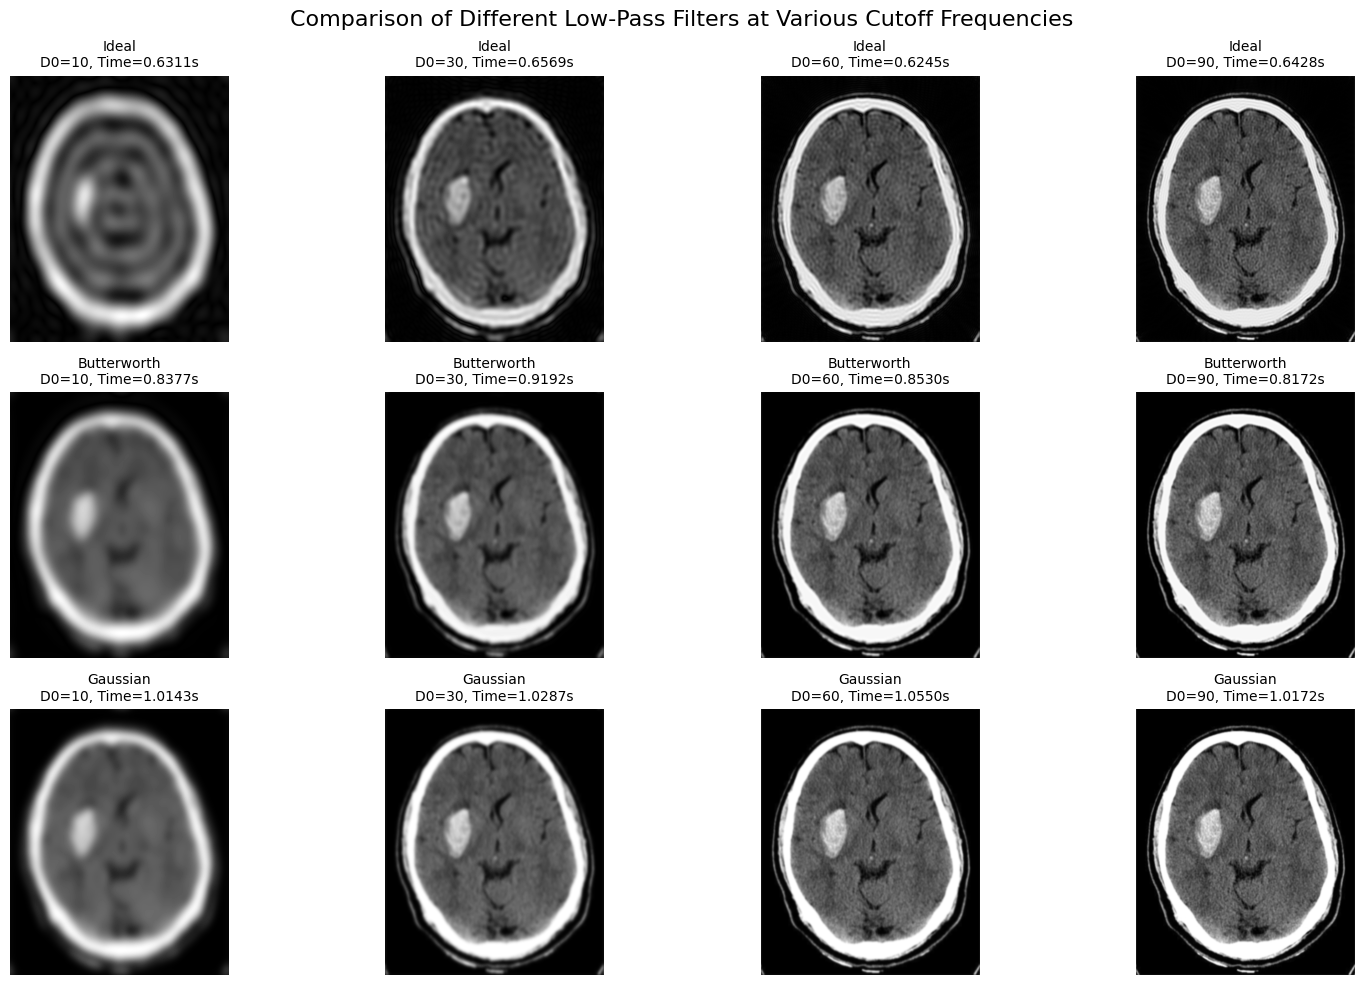

In [ ]:
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy import fft
from skimage import io, color

def comparison (img):

    # Compute 2D DFT and shift
    F = fft.fft2(img)
    F_shifted = fft.fftshift(F)


    filters = {
        "Ideal": Ideal_LPF,
        "Butterworth": butterworth_LPF,
        "Gaussian": gaussian_LPF
    }

    D0_values = [10, 30, 60, 90]   # Cutoff frequencies to test
    butterworth_order = 2          # We'll use n=2 for Butterworth

    # We'll create a figure with rows=number_of_filters, columns=number_of_D0_values
    num_filters = len(filters)
    num_cutoffs = len(D0_values)

    fig, axes = plt.subplots(nrows=num_filters, ncols=num_cutoffs, figsize=(16, 10))
    fig.suptitle("Comparison of Different Low-Pass Filters at Various Cutoff Frequencies", fontsize=16)

    for row, (filter_name, filter_func) in enumerate(filters.items()):
        for col, D0 in enumerate(D0_values):

            start_time = time.time()

            # Generate filter mask
            if filter_name == "Butterworth":
                H = filter_func(img, D0=D0, n=butterworth_order)
            else:
                H = filter_func(img, D0=D0)

            # Apply filter in frequency domain
            F_filtered = F_shifted * H

            # Inverse shift & iFFT
            F_ishift = fft.ifftshift(F_filtered)
            filtered_img = np.abs(fft.ifft2(F_ishift))

            end_time = time.time()
            elapsed = end_time - start_time

            # Display
            ax = axes[row, col]
            ax.imshow(filtered_img, cmap='gray')
            ax.set_title(f"{filter_name}\nD0={D0}, Time={elapsed:.4f}s", fontsize=10)
            ax.axis('off')

    plt.tight_layout()
    plt.show()

img2 = plt.imread('brain.jpg')
comparison(img2)


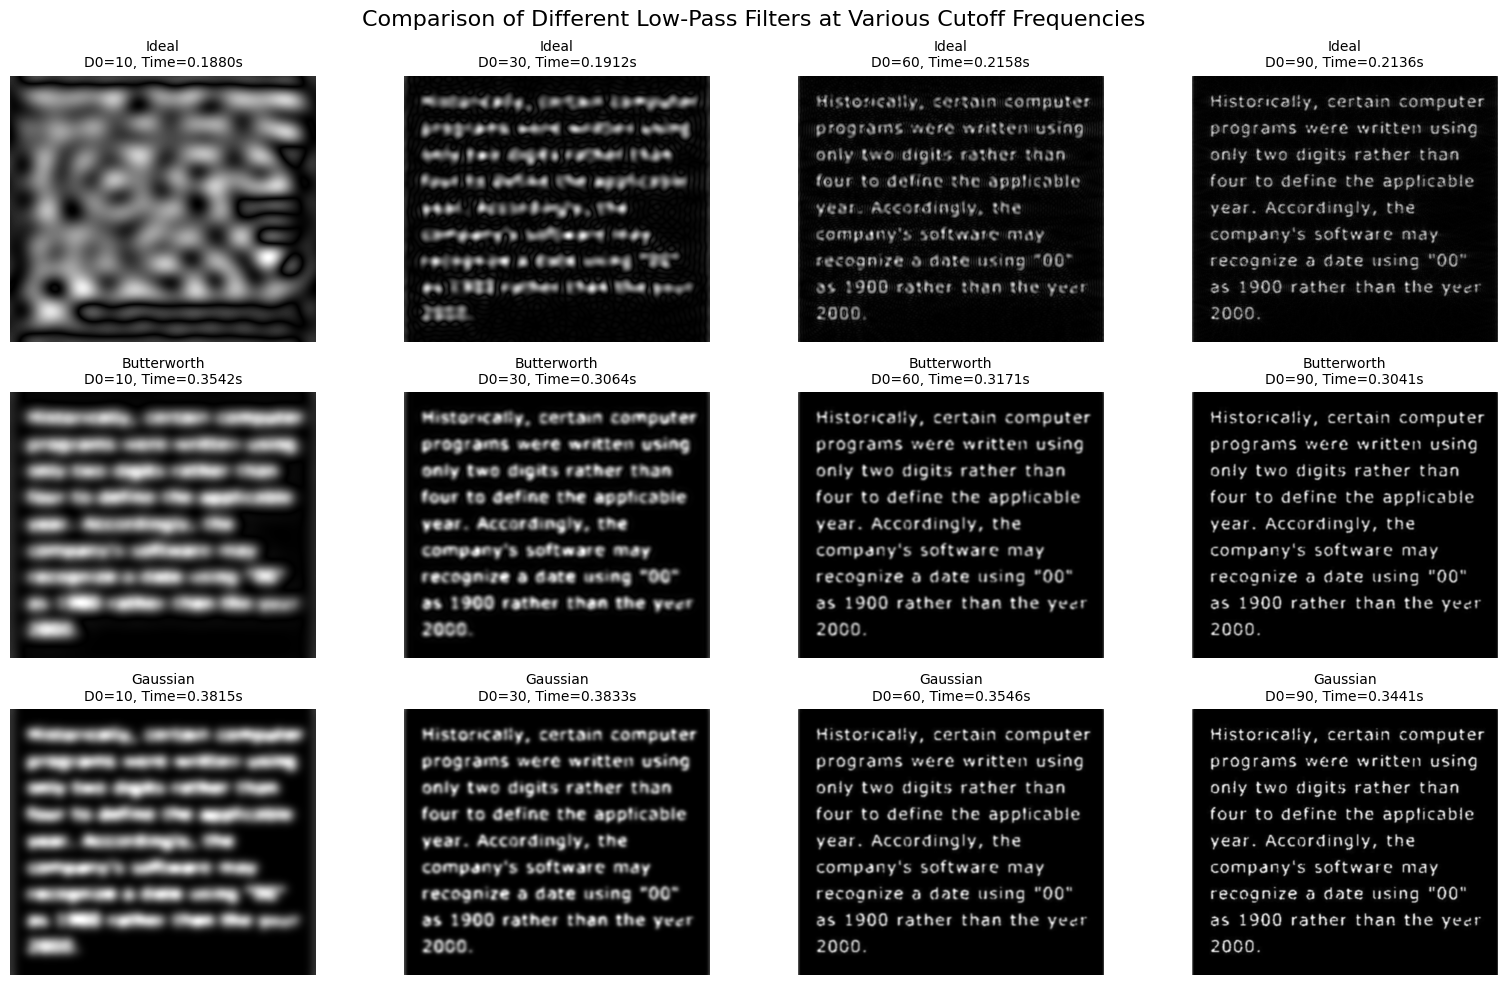

In [8]:
img3 = plt.imread('broken_text.jpg')
img3 = color.rgb2gray(img3)

comparison(img3)

### Mean (Box) LPF
unlike previous filters where the filter was applied in the frequency domain, Mean LPF is a simple filter that averages the nearby pixel values:
$$
w = \frac{1}{N^2} 
\begin{bmatrix} 
1 & 1 & 1 \\ 
1 & 1 & 1 \\ 
1 & 1 & 1 
\end{bmatrix}
$$
*   The main draw back of this filter is the significant bluring of the edges 
*   On the other hands is faster that other filters

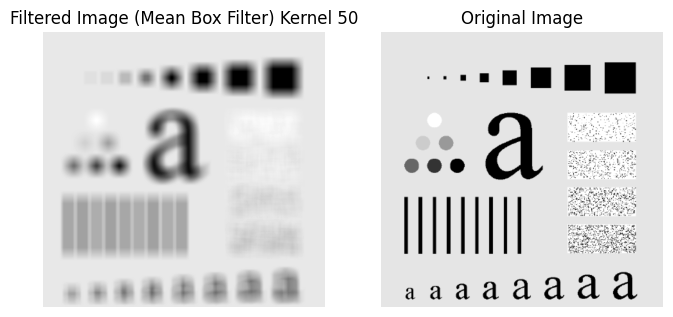

In [192]:
from scipy.signal import convolve2d

# Define the Mean (Box) Low-Pass Filter function using convolve2d
def mean_low_pass_filter(img, kernel_size=10):
    """
    Applies a Mean (Box) Low-Pass Filter using efficient 2D convolution.
    """
    # Create a mean filter (box filter) kernel
    kernel = np.ones((kernel_size, kernel_size), dtype=np.float32) / (kernel_size ** 2)

    # Apply 2D convolution
    img_filtered = convolve2d(img, kernel, mode='same', boundary='symm')

    return img_filtered

# Apply the Mean (Box) filter
kernel_size = 50  # Size of the mean filter kernel
mean_img_filtered = mean_low_pass_filter(img, kernel_size)

fig, ax = plt.subplots(1, 2, figsize=(8, 4))

ax[0].imshow(mean_img_filtered, cmap='gray')
ax[0].set_title("Filtered Image (Mean Box Filter) Kernel {}".format(kernel_size))
ax[0].axis('off')

ax[1].imshow(img, cmap='gray')
ax[1].set_title("Original Image")
ax[1].axis('off')

plt.show()


### Median Filter
Replaces each pixel with the median of its neighbors.
* Removes salt-and-pepper noise while preserving edges. Noise reduction (especially for impulse noise).

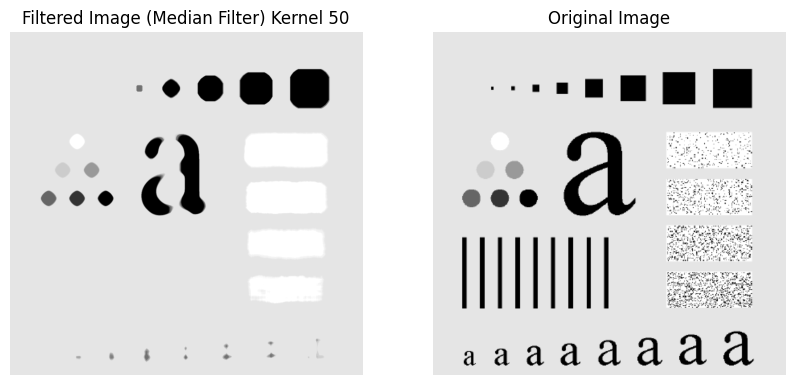

In [23]:
# Define the Median Filter function using convolve2d
def median_LPF(img, kernel_size=10):
    """
    Applies a Median Filter using a sliding window approach with convolve2d.
    Since convolve2d does not support median, we implement it manually.
    """
    M, N = img.shape  # Image dimensions
    pad_size = kernel_size // 2  # Padding for border handling
    img_padded = np.pad(img, pad_size, mode='reflect')  # Reflect padding to avoid artifacts
    img_filtered = np.zeros_like(img, dtype=np.float32)  # Initialize filtered image

    # Perform convolution-like windowing but apply the median filter manually
    for i in range(M):
        for j in range(N):
            region = img_padded[i:i + kernel_size, j:j + kernel_size]  # Extract local region
            img_filtered[i, j] = np.median(region)  # Apply median filtering

    return img_filtered

# Apply the Median filter
kernel_size = 50  # Kernel size for median filter
median_img_filtered_scratch = median_LPF(img, kernel_size)

# Plot the results
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(median_img_filtered_scratch, cmap='gray')
ax[0].set_title("Filtered Image (Median Filter) Kernel {}".format(kernel_size))
ax[0].axis('off')

ax[1].imshow(img, cmap='gray')
ax[1].set_title("Original Image")
ax[1].axis('off')

plt.show()

### Ideal HPF
Removes all frequencies below a certain cutoff frequency.
$$
H(f) =
\begin{cases} 
0, & f \leq f_c \\
1, & f > f_c
\end{cases}
$$
* Perfectly sharp edges but introduces ringing artifacts.
* Theoretical applications, not practical due to artifacts.

(-0.5, 1110.5, 1082.5, -0.5)

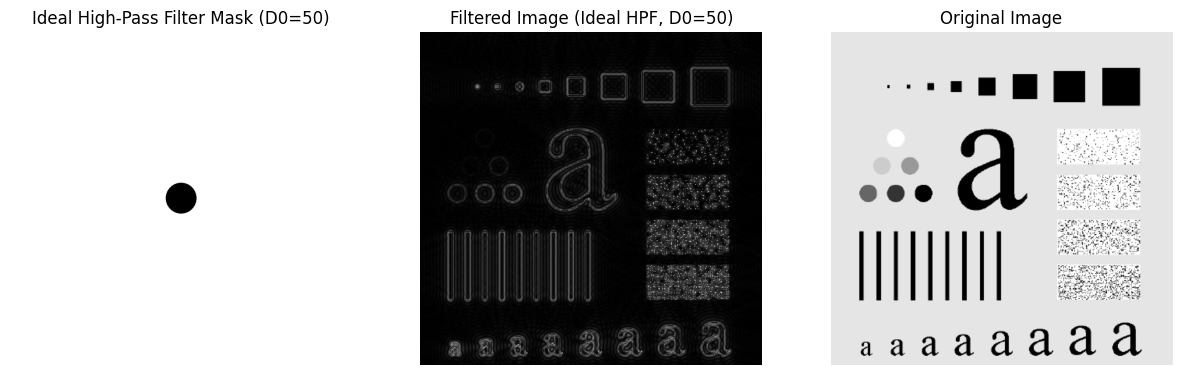

In [ ]:
# Define the Ideal High-Pass Filter (HPF) function
def Ideal_HPF(img, D0):
    """
    Creates an Ideal High-Pass Filter mask.
    - D0: Cutoff frequency (higher values preserve more high frequencies).
    """
    M, N = img.shape
    H = np.zeros((M, N), dtype=np.float32)

    # Looping through each pixel in the frequency domain and computing the Euclidean distance from the center
    for u in range(M):
        for v in range(N):
            # Compute distance from the center (low frequencies are at the center)
            D = np.sqrt((u - M / 2) ** 2 + (v - N / 2) ** 2)
            if D > D0:
                H[u, v] = 1  # Preserve high frequencies
            else:
                H[u, v] = 0  # Block low frequencies

    return H

# Define cutoff frequency for Ideal HPF
D0 = 50

# Compute the Ideal HPF mask
H_HPF = Ideal_HPF(img, D0)

# Apply Fourier Transform and shift zero frequency component to center
F = np.fft.fft2(img)
F_shifted = np.fft.fftshift(F)

# Apply the Ideal High-Pass Filter in the frequency domain
F_filtered_HPF = F_shifted * H_HPF # Element-wise multiplication

# Inverse Fourier Transform to get the filtered image
F_ishift_HPF = np.fft.ifftshift(F_filtered_HPF) # Shift zero components back to the corners
ideal_HPF_img_filtered = np.abs(np.fft.ifft2(F_ishift_HPF)) # abs() ensures that the results are real numbers since ifft2() may return complex numbers.

# Display the filter mask and the filtered image
plt.figure(figsize=(15, 6))

plt.subplot(1, 3, 1)
plt.imshow(H_HPF, cmap='gray')
plt.title('Ideal High-Pass Filter Mask (D0={})'.format(D0))
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(ideal_HPF_img_filtered, cmap='gray')
plt.title('Filtered Image (Ideal HPF, D0={})'.format(D0))
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(img, cmap='gray')
plt.title('Original Image')
plt.axis('off')


### Butterworth HPF
Smooth transition between low-frequency suppression and high-frequency preservation.

$$
H(f) =1-  \frac{1}{1 + \left( \frac{D(u,c)}{D_0} \right)^{2n}}
$$


* Removes gradual variations while reducing ringing effects.
* Enhancing textures, medical imaging.

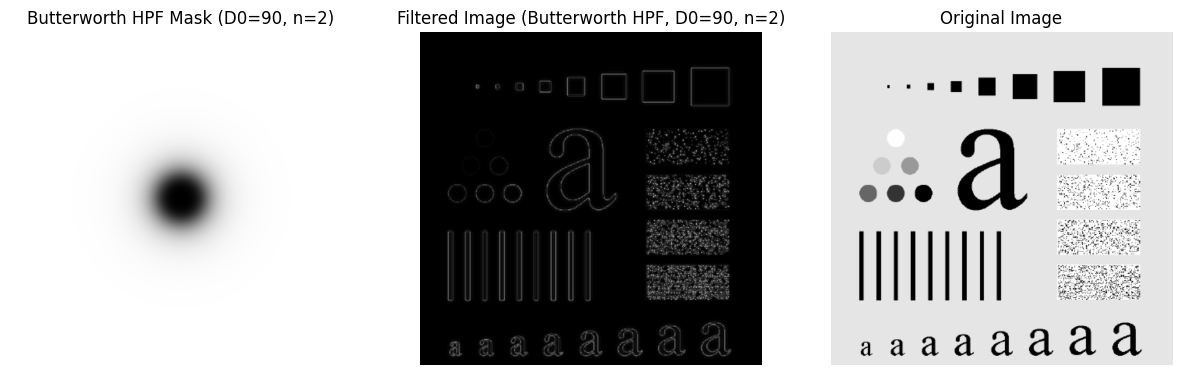

In [194]:
# Define the Butterworth High-Pass Filter (HPF) function
def butterworth_high_pass_filter(img, D0=30, n=2):
    """
    Creates a Butterworth high-pass filter of size (M, N) with cutoff frequency D0 and order n.
    """
    M, N = img.shape
    H = np.zeros((M, N), dtype=np.float32)  # Initialize filter mask

    for u in range(M):
        for v in range(N):
            # Compute distance from center (low frequencies are at the center)
            D = np.sqrt((u - M / 2) ** 2 + (v - N / 2) ** 2)
            # Butterworth function: smooth high-pass transition
            H[u, v] = 1 - (1 / (1 + (D / D0) ** (2 * n)))  # HPF = 1 - LPF

    return H

# Define cutoff frequency and filter order for Butterworth HPF
D0 = 90  # Cutoff frequency
n = 2    # Order of the filter

# Compute Butterworth HPF mask
H_butterworth_HPF = butterworth_high_pass_filter(img, D0, n)

# Apply Fourier Transform and shift zero frequency component to center
F = np.fft.fft2(img)
F_shifted = np.fft.fftshift(F)

# Apply the Butterworth high-pass filter in the frequency domain
F_filtered_HPF = F_shifted * H_butterworth_HPF

# Inverse Fourier Transform to get the filtered image
F_ishift_HPF = np.fft.ifftshift(F_filtered_HPF)

butterworth_HPF_img_filtered = np.abs(np.fft.ifft2(F_ishift_HPF))

# Plot the results
fig, ax = plt.subplots(1, 3, figsize=(15, 6))

ax[0].imshow(H_butterworth_HPF, cmap='gray')
ax[0].set_title("Butterworth HPF Mask (D0={}, n={})".format(D0, n))
ax[0].axis('off')

ax[1].imshow(butterworth_HPF_img_filtered, cmap='gray')
ax[1].set_title("Filtered Image (Butterworth HPF, D0={}, n={})".format(D0, n))
ax[1].axis('off')

ax[2].imshow(img, cmap='gray')
ax[2].set_title("Original Image")
ax[2].axis('off')

plt.show()

### Gaussian HPF


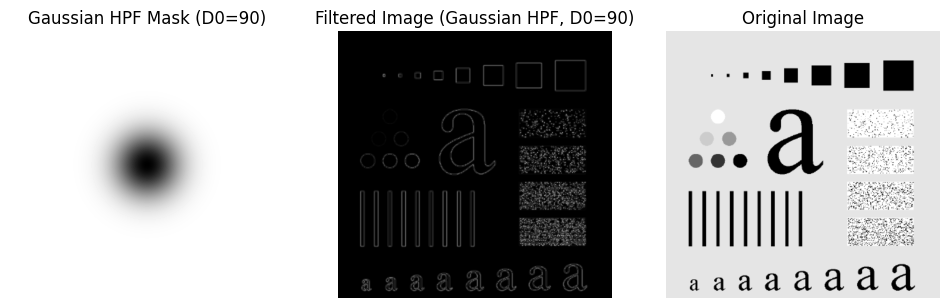

In [ ]:
# Define the Gaussian High-Pass Filter (HPF) function
def gaussian_high_pass_filter(img, D0=30):
    """
    Creates a Gaussian high-pass filter of size (M, N) with cutoff frequency D0.
    """
    M, N = img.shape

    H = np.zeros((M, N), dtype=np.float32)  # Initialize filter mask

    for u in range(M):
        for v in range(N):
            # Compute distance from center (low frequencies are at the center)
            D = np.sqrt((u - M / 2) ** 2 + (v - N / 2) ** 2)
            # Gaussian function: smooth high-pass transition
            H[u, v] = 1 - np.exp(- (D ** 2) / (2 * (D0 ** 2)))  # HPF = 1 - LPF

    return H

# Define cutoff frequency for Gaussian HPF
D0 = 90  # Cutoff frequency

# Generate Gaussian HPF mask
H_gaussian_HPF = gaussian_high_pass_filter(img, D0)

# Apply Fourier Transform and shift zero frequency component to center
F = np.fft.fft2(img)
F_shifted = np.fft.fftshift(F) # Shift zero components to the center

# Apply the Gaussian high-pass filter in the frequency domain
F_filtered_HPF = F_shifted * H_gaussian_HPF

# Inverse Fourier Transform to get the filtered image
F_ishift_HPF = np.fft.ifftshift(F_filtered_HPF)
gaussian_HPF_img_filtered = np.abs(np.fft.ifft2(F_ishift_HPF))
# Plot the results
fig, ax = plt.subplots(1, 3, figsize=(12, 6))

ax[0].imshow(H_gaussian_HPF, cmap='gray')
ax[0].set_title("Gaussian HPF Mask (D0={})".format(D0))
ax[0].axis('off')

ax[1].imshow(gaussian_HPF_img_filtered, cmap='gray')
ax[1].set_title("Filtered Image (Gaussian HPF, D0={})".format(D0))
ax[1].axis('off')

ax[2].imshow(img, cmap='gray')
ax[2].set_title("Original Image")
ax[2].axis('off')

plt.show()


### Laplacian Filter
A second-order derivative filter that enhances fine edges.

$$
w =
\begin{bmatrix} 
0 & -1 & 0 \\ 
-1 & 4 & -1 \\ 
0 & -1 & 0 
\end{bmatrix}
$$


* Highlights fine edges but amplifies noise.
* Edge detection and sharpening.

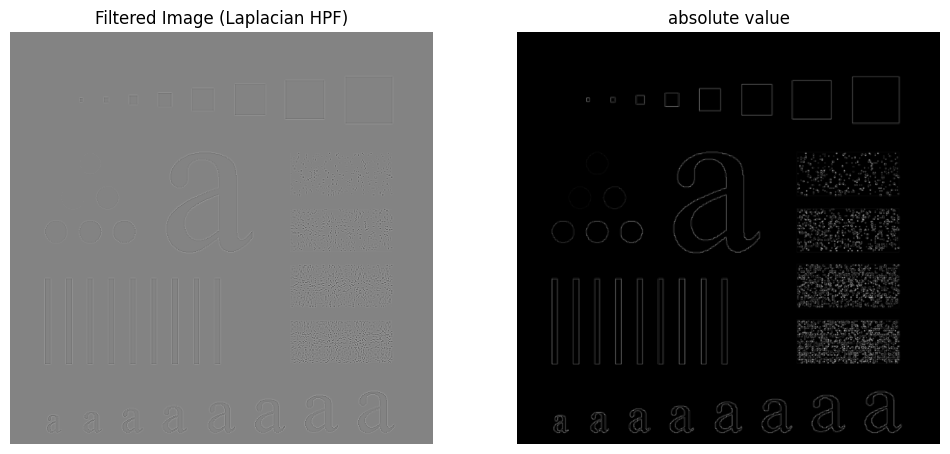

In [ ]:
# Define the Laplacian High-Pass Filter (HPF) function
def laplacian_high_pass_filter(img):
    """
    Applies a Laplacian High-Pass Filter using convolution with convolve2d.
    """
    # Define the Laplacian kernel (3x3)
    laplacian_kernel = np.array([[ 0, -1,  0],
                                 [-1,  4, -1],
                                 [ 0, -1,  0]], dtype=np.float32)

    # Apply convolution using convolve2d (same mode keeps image size)
    lap = convolve2d(img, laplacian_kernel, mode='same', boundary='symm') #applying kernel to the image

    return lap

# Apply the Laplacian High-Pass Filter
laplacian_HPF_img_filtered = laplacian_high_pass_filter(img)
lap_abss = np.abs(laplacian_HPF_img_filtered)
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].imshow(laplacian_HPF_img_filtered, cmap='gray')
ax[0].set_title("Filtered Image (Laplacian HPF)")
ax[0].axis('off')

ax[1].imshow(lap_abss, cmap='gray')
ax[1].set_title("absolute value")
ax[1].axis('off')

plt.show()


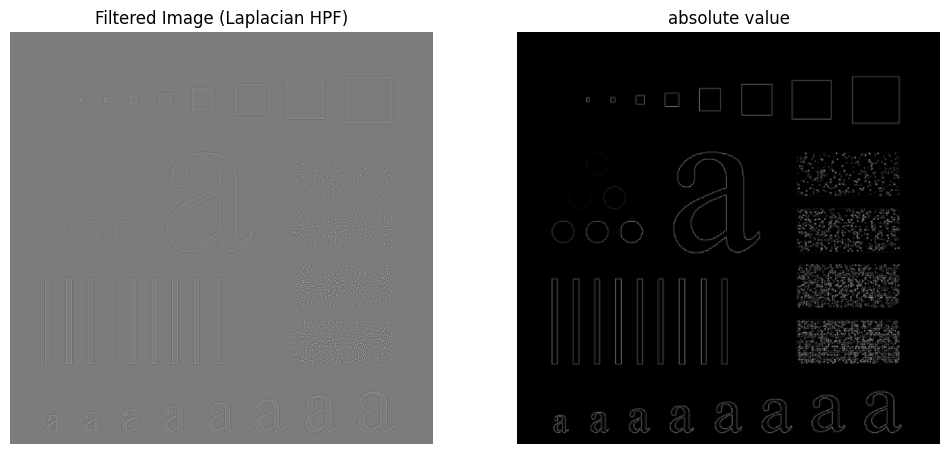

In [24]:
# Define the Laplacian High-Pass Filter (HPF) function
def laplacian_high_pass_filter2(img):
    """
    Applies a Laplacian High-Pass Filter using convolution with convolve2d.
    """
    # Define the Laplacian kernel (3x3)
    laplacian_kernel = np.array([[ 1, 1,  1],
                                 [ 1, -8, 1],
                                 [ 1, 1,  1]], dtype=np.float32)

    # Apply convolution using convolve2d (same mode keeps image size)
    lap = convolve2d(img, laplacian_kernel, mode='same', boundary='symm')
    # lap_abs = np.abs(lap)

    return lap

# Apply the Laplacian High-Pass Filter
laplacian_HPF_img_filtered = laplacian_high_pass_filter2(img)
lap_abss = np.abs(laplacian_HPF_img_filtered)
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].imshow(laplacian_HPF_img_filtered, cmap='gray')
ax[0].set_title("Filtered Image (Laplacian HPF)")
ax[0].axis('off')

ax[1].imshow(lap_abss, cmap='gray')
ax[1].set_title("absolute value")
ax[1].axis('off')

plt.show()


### Sobel Filter
A first-order derivative filter that detects horizontal and vertical edges.

$$
G_x =
\begin{bmatrix} 
-1 & 0 & 1 \\ 
-2 & 0 & 2 \\ 
-1 & 0 & 1 
\end{bmatrix}
,\quad
G_y =
\begin{bmatrix} 
-1 & -2 & -1 \\ 
0 & 0 & 0 \\ 
1 & 2 & 1 
\end{bmatrix}
$$


* Detects edges along x and y directions.
* Edge detection, feature extraction.

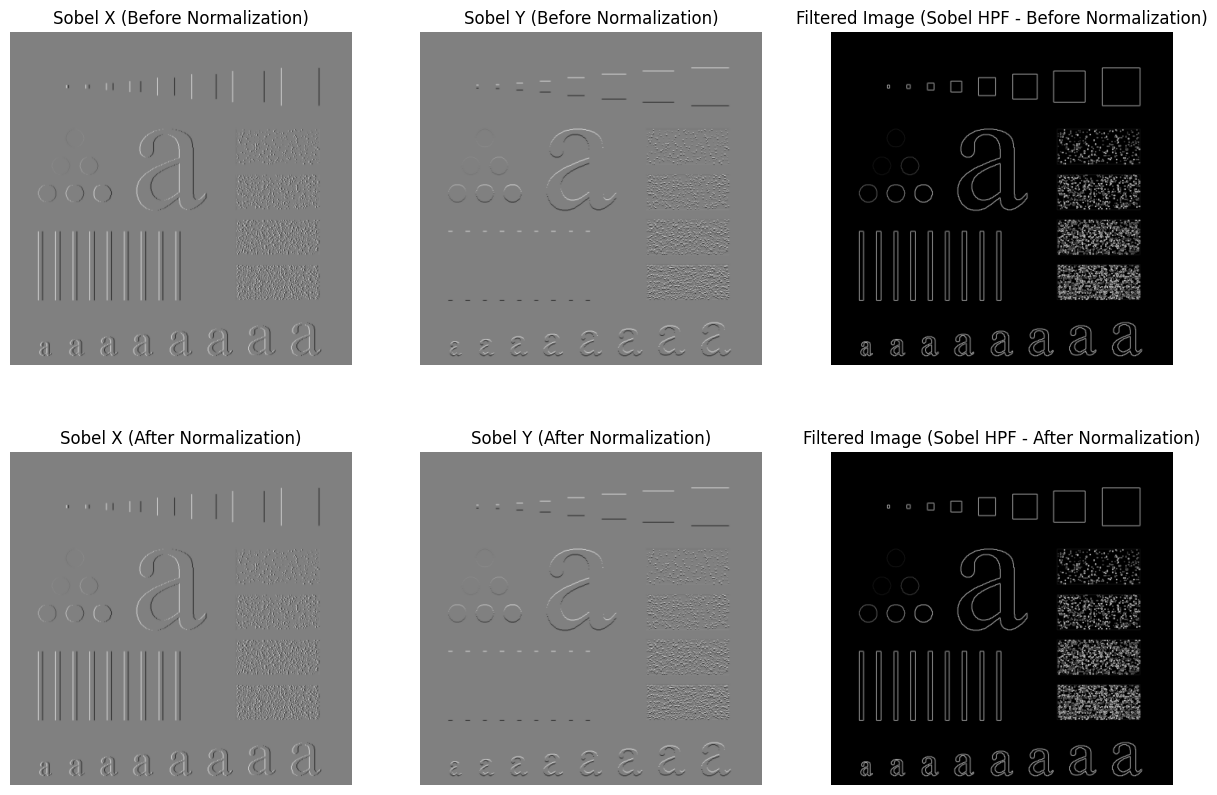

In [ ]:
# Define the Sobel High-Pass Filter (HPF) function
def sobel_high_pass_filter(img):
    """
    Applies a Sobel High-Pass Filter using convolution with convolve2d.
    Detects edges in both horizontal and vertical directions.
    """
    # Define Sobel kernels for detecting horizontal and vertical edges
    sobel_x = np.array([[-1, 0, 1],
                        [-2, 0, 2],
                        [-1, 0, 1]], dtype=np.float32)

    sobel_y = np.array([[-1, -2, -1],
                        [ 0,  0,  0],
                        [ 1,  2,  1]], dtype=np.float32)

    # Apply convolution using convolve2d for both Sobel operators
    img_sobel_x = convolve2d(img, sobel_x, mode='same', boundary='symm')
    img_sobel_y = convolve2d(img, sobel_y, mode='same', boundary='symm')

    # Compute the gradient magnitude
    img_sobel = np.sqrt(img_sobel_x**2 + img_sobel_y**2)

    return img_sobel, img_sobel_x, img_sobel_y

# Apply the Sobel High-Pass Filter
sobel_HPF_img_filtered, img_sobel_x, img_sobel_y = sobel_high_pass_filter(img)

# Since convolution results in values that can be negative or outside the standard grayscale range [0, 255], normalization is applied:
sobel_HPF_img_filtered_norm = sobel_HPF_img_filtered - np.min(sobel_HPF_img_filtered)
sobel_HPF_img_filtered_norm = (sobel_HPF_img_filtered / np.max(sobel_HPF_img_filtered)) * 255# Apply the Sobel High-Pass Filter



# Normalize Sobel X and Y images
img_sobel_x_norm = img_sobel_x - np.min(img_sobel_x)
img_sobel_x_norm = (img_sobel_x_norm / np.max(img_sobel_x_norm)) * 255

img_sobel_y_norm = img_sobel_y - np.min(img_sobel_y)
img_sobel_y_norm = (img_sobel_y_norm / np.max(img_sobel_y_norm)) * 255

# Plot the results
fig, ax = plt.subplots(2, 3, figsize=(15, 10))

# Row 1: Before Normalization
ax[0, 0].imshow(img_sobel_x, cmap='gray')
ax[0, 0].set_title("Sobel X (Before Normalization)")
ax[0, 0].axis('off')

ax[0, 1].imshow(img_sobel_y, cmap='gray')
ax[0, 1].set_title("Sobel Y (Before Normalization)")
ax[0, 1].axis('off')

ax[0, 2].imshow(sobel_HPF_img_filtered, cmap='gray')
ax[0, 2].set_title("Filtered Image (Sobel HPF - Before Normalization)")
ax[0, 2].axis('off')

# Row 2: After Normalization
ax[1, 0].imshow(img_sobel_x_norm, cmap='gray')
ax[1, 0].set_title("Sobel X (After Normalization)")
ax[1, 0].axis('off')

ax[1, 1].imshow(img_sobel_y_norm, cmap='gray')
ax[1, 1].set_title("Sobel Y (After Normalization)")
ax[1, 1].axis('off')

ax[1, 2].imshow(sobel_HPF_img_filtered_norm, cmap='gray')
ax[1, 2].set_title("Filtered Image (Sobel HPF - After Normalization)")
ax[1, 2].axis('off')

plt.show()
